# Comparaison des bandes de fréquences : Sleep I vs Sleep II

**Question** : Est-ce que les puissances theta (4–8 Hz), alpha (8–13 Hz) et beta (13–30 Hz) changent entre le sommeil *avant* l'apprentissage (Sleep I) et le sommeil *après* (Sleep II) ?

**Comparaisons effectuées**
1. NREM I vs NREM II — effet de l'apprentissage sur le sommeil NREM
2. REM I vs REM II   — effet de l'apprentissage sur le sommeil REM
3. NREM vs REM global — comparaison des deux états de sommeil

**Méthode** : PSD par méthode de Welch → puissance relative par bande → test de Mann–Whitney U (bilatéral, non-paramétrique).

Régions : `dHPC_lfp` (hippocampe dorsal), `vHPC_lfp` (hippocampe ventral), `bla_lfp` (amygdale).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import mannwhitneyu

# Core functions built for this project
from core import FREQ_BANDS

FS = 1250  # Hz — sampling frequency

## 1. Chargement des données

In [2]:
df = pd.read_pickle("data/lfp_epochs_with_spikes_by_region-rw-2.pkl")

print("Epoch labels disponibles :", sorted(df["epoch_label"].unique()))
print()

summary = df.groupby("epoch_label").apply(
    lambda g: pd.Series({
        "n_epochs": len(g),
        "total_duration_s": (g["t_end"] - g["t_start"]).sum().round(1),
        "mean_duration_s" : (g["t_end"] - g["t_start"]).mean().round(1),
    })
)
print(summary)

Epoch labels disponibles : ['NREM I', 'NREM II', 'REM I', 'REM II']

             n_epochs  total_duration_s  mean_duration_s
epoch_label                                             
NREM I          184.0            5555.0             30.2
NREM II         203.0            5128.0             25.3
REM I           178.0            2651.0             14.9
REM II          193.0            2164.0             11.2


In [3]:
nrem1 = df[df["epoch_label"] == "NREM I"].reset_index(drop=True)
nrem2 = df[df["epoch_label"] == "NREM II"].reset_index(drop=True)
rem1  = df[df["epoch_label"] == "REM I"].reset_index(drop=True)
rem2  = df[df["epoch_label"] == "REM II"].reset_index(drop=True)

for name, grp in [("NREM I", nrem1), ("NREM II", nrem2), ("REM I", rem1), ("REM II", rem2)]:
    print(f"{name} : {len(grp)} epochs — durées : {[int(r['t_end']-r['t_start']) for _, r in grp.iterrows()]} s")


NREM I : 184 epochs — durées : [8, 15, 42, 9, 28, 12, 10, 18, 11, 25, 14, 10, 9, 18, 7, 12, 15, 11, 4, 36, 24, 15, 2, 49, 10, 62, 20, 24, 63, 9, 2, 16, 9, 1, 9, 16, 5, 2, 6, 13, 4, 11, 18, 2, 9, 13, 14, 13, 5, 24, 5, 24, 8, 9, 27, 7, 9, 45, 38, 6, 38, 17, 31, 22, 15, 28, 18, 3, 6, 12, 100, 50, 15, 4, 17, 42, 36, 8, 5, 30, 4, 6, 7, 5, 2, 4, 9, 2, 7, 8, 9, 5, 8, 9, 18, 6, 12, 8, 24, 21, 11, 15, 13, 11, 66, 65, 7, 11, 84, 35, 210, 14, 7, 5, 99, 10, 98, 47, 33, 25, 31, 27, 118, 13, 326, 62, 49, 74, 70, 39, 26, 83, 31, 41, 3, 21, 24, 46, 23, 25, 424, 3, 5, 86, 38, 20, 176, 30, 102, 111, 11, 30, 41, 34, 125, 5, 8, 86, 6, 84, 124, 10, 2, 28, 28, 23, 13, 9, 8, 8, 9, 15, 18, 12, 86, 10, 14, 18, 4, 3, 7, 7, 5, 38] s
NREM II : 203 epochs — durées : [52, 96, 10, 10, 185, 27, 60, 10, 32, 14, 35, 9, 9, 11, 3, 7, 10, 13, 135, 10, 5, 78, 14, 8, 15, 9, 4, 11, 9, 9, 5, 6, 4, 5, 13, 18, 8, 28, 10, 15, 24, 44, 4, 10, 12, 19, 29, 9, 23, 3, 28, 16, 15, 8, 2, 20, 30, 43, 135, 6, 108, 36, 49, 2, 3, 3, 6, 190,

## 2. Vue d'ensemble spectrale (PSD)

Densité spectrale de puissance (méthode de Welch) moyennée sur toutes les epochs de chaque condition, canal dHPC. Les bandes sont indiquées pour référence.

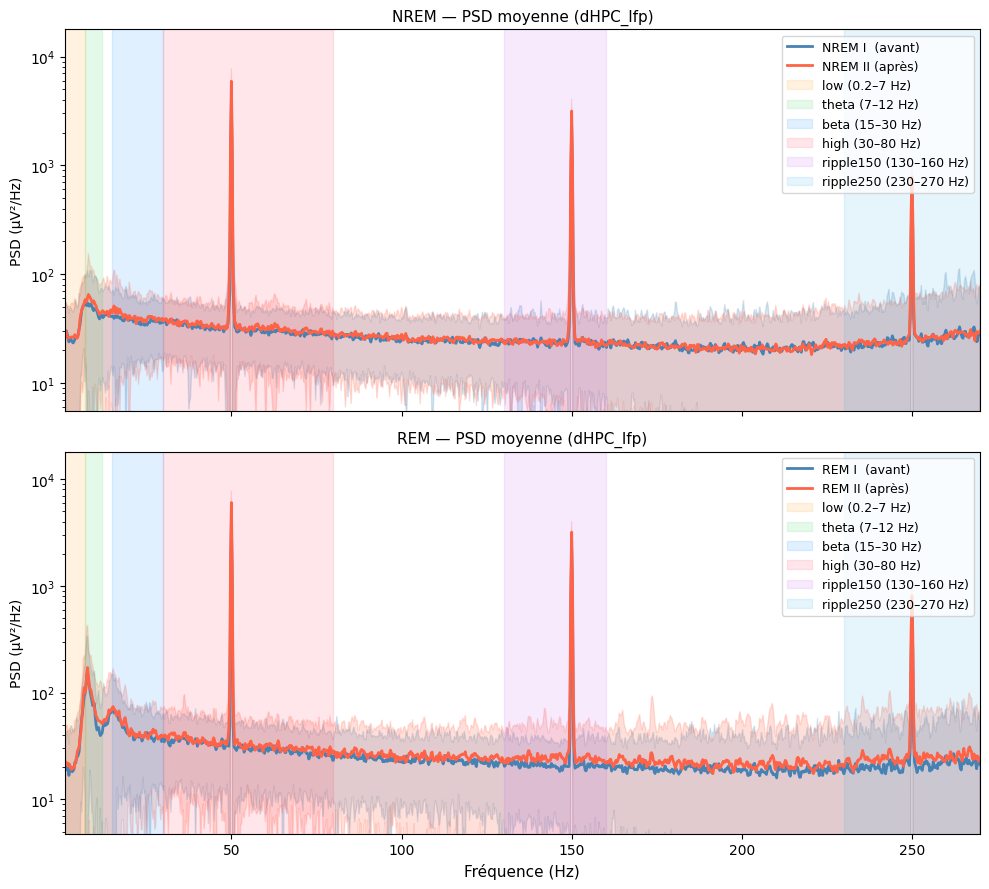

In [4]:
CHANNEL = "dHPC_lfp"

def epoch_psds(epoch_df, channel=CHANNEL, fs=FS):
    """Compute Welch PSD for every epoch row; return (freqs, psds array).

    nperseg/noverlap are clipped per-signal so no UserWarning is raised.
    All PSDs are interpolated onto a common frequency axis derived from the
    first epoch so the result can always be stacked into a 2-D array.
    """
    TARGET_NPERSEG = 4 * fs
    TARGET_NOVERLAP = 2 * fs

    psds, freqs_ref = [], None
    for _, row in epoch_df.iterrows():
        lfp = np.asarray(row[channel])
        nperseg  = min(TARGET_NPERSEG,  len(lfp))
        noverlap = min(TARGET_NOVERLAP, nperseg - 1)
        f, psd = welch(lfp, fs=fs, nperseg=nperseg, noverlap=noverlap)

        if freqs_ref is None:
            freqs_ref = f
            psds.append(psd)
        else:
            if len(f) != len(freqs_ref):
                psd = np.interp(freqs_ref, f, psd)
            psds.append(psd)

    return freqs_ref, np.array(psds)


# ── Compute all PSDs once, cache by (sleep_type, channel) ─────────────────
ALL_GROUPS = {
    "NREM I":  nrem1,
    "NREM II": nrem2,
    "REM I":   rem1,
    "REM II":  rem2,
}
ALL_CHANNELS = ["dHPC_lfp", "vHPC_lfp", "bla_lfp"]

psd_cache = {}
freqs = None

for label, grp in ALL_GROUPS.items():
    for ch in ALL_CHANNELS:
        f, psds = epoch_psds(grp, channel=ch)
        psd_cache[(label, ch)] = psds
        if freqs is None:
            freqs = f

psds_nrem1 = psd_cache[("NREM I",  CHANNEL)]
psds_nrem2 = psd_cache[("NREM II", CHANNEL)]
psds_rem1  = psd_cache[("REM I",   CHANNEL)]
psds_rem2  = psd_cache[("REM II",  CHANNEL)]

FMIN = max(1.0, min(lo for lo, hi in FREQ_BANDS.values()))
FMAX = max(hi for lo, hi in FREQ_BANDS.values())
freq_mask = (freqs >= FMIN) & (freqs <= FMAX)

# Colour palette — one colour per band, cycles if more than 7 bands
_PALETTE = ["#FF9500", "#30D158", "#0A84FF", "#FF375F", "#BF5AF2", "#32ADE6", "#FFD60A"]
BAND_COLORS_MAP = {name: _PALETTE[i % len(_PALETTE)]
                   for i, name in enumerate(FREQ_BANDS)}

# ── PSD plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

for ax, (psd1, psd2, sleep_type) in zip(axes, [
    (psds_nrem1, psds_nrem2, "NREM"),
    (psds_rem1,  psds_rem2,  "REM"),
]):
    for label, psds, color in [
        (f"{sleep_type} I  (avant)", psd1, "steelblue"),
        (f"{sleep_type} II (après)", psd2, "tomato"),
    ]:
        mean_psd = psds.mean(axis=0)
        std_psd  = psds.std(axis=0)
        ax.semilogy(freqs[freq_mask], mean_psd[freq_mask], color=color, lw=2, label=label)
        ax.fill_between(
            freqs[freq_mask],
            np.maximum(mean_psd[freq_mask] - std_psd[freq_mask], 1e-9),
            mean_psd[freq_mask] + std_psd[freq_mask],
            alpha=0.2, color=color,
        )

    for band_name, (f_lo, f_hi) in FREQ_BANDS.items():
        color = BAND_COLORS_MAP[band_name]
        ax.axvspan(max(f_lo, FMIN), min(f_hi, FMAX), color=color, alpha=0.12,
                   label=f"{band_name} ({f_lo}–{f_hi} Hz)")

    all_means = np.concatenate([psd1[:, freq_mask].mean(axis=0),
                                 psd2[:, freq_mask].mean(axis=0)])
    ax.set_ylim(all_means.min() * 0.3, all_means.max() * 3)
    ax.set_ylabel("PSD (µV²/Hz)", fontsize=10)
    ax.set_title(f"{sleep_type} — PSD moyenne ({CHANNEL})", fontsize=11)
    ax.legend(fontsize=9)

axes[-1].set_xlabel("Fréquence (Hz)", fontsize=11)
axes[-1].set_xlim(FMIN, FMAX)
plt.tight_layout()
plt.show()

In [5]:
def band_relative_power(psd, freqs, f_low, f_high, f_total_max=100):
    """Fraction of total power in [f_low, f_high]. Returns NaN if total is zero."""
    band_mask  = (freqs >= f_low)  & (freqs <= f_high)
    total_mask = (freqs >= 0.5)    & (freqs <= f_total_max)
    total = psd[total_mask].sum()
    if total == 0 or not np.isfinite(total):
        return np.nan
    return psd[band_mask].sum() / total


def all_band_relative_powers(psds, freqs, bands=None):
    """Return dict {band_name: np.ndarray of per-epoch relative power}."""
    if bands is None:
        bands = FREQ_BANDS
    return {
        name: np.array([band_relative_power(p, freqs, lo, hi) for p in psds])
        for name, (lo, hi) in bands.items()
    }


def _eta_sq_label(eta2):
    """Qualitative label for η² (Cohen 1988 thresholds)."""
    if eta2 < 0.01:  return "negligeable"
    if eta2 < 0.06:  return "petit"
    if eta2 < 0.14:  return "moyen"
    return "grand"


def stat_label(a, b):
    """
    Mann-Whitney U: p-value, stars, direction (rank-biserial r) and η².
    Direction only shown when significant (p < 0.05).
    """
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if len(a) < 2 or len(b) < 2:
        return "n.a."
    U, p = mannwhitneyu(a, b, alternative="two-sided")

    n_a, n_b = len(a), len(b)
    # rank-biserial r: +1 → a>b, −1 → b>a
    r = 2 * U / (n_a * n_b) - 1
    # η² = Z² / N
    mu_U    = n_a * n_b / 2
    sigma_U = np.sqrt(n_a * n_b * (n_a + n_b + 1) / 12)
    Z       = (U - mu_U) / sigma_U
    eta2    = Z**2 / (n_a + n_b)

    if p < 0.001:
        sig = f"p={p:.2e} ***"
    elif p < 0.01:
        sig = f"p={p:.3f} **"
    elif p < 0.05:
        sig = f"p={p:.3f} *"
    else:
        return f"p={p:.3f} n.s."

    direction = "A>B" if r > 0 else "A<B"
    return f"{sig} · {direction} · η²={eta2:.3f} ({_eta_sq_label(eta2)})"

In [6]:
CHANNELS_LIST  = ["dHPC_lfp", "vHPC_lfp", "bla_lfp"]
CHANNEL_LABELS = {"dHPC_lfp": "dHPC", "vHPC_lfp": "vHPC", "bla_lfp": "BLA"}

# band_powers[(label, channel)] → {band_name: np.ndarray of per-epoch relative power}
band_powers = {
    (lbl, ch): all_band_relative_powers(psd_cache[(lbl, ch)], freqs)
    for lbl in ALL_GROUPS
    for ch in CHANNELS_LIST
}

# Quick summary
for lbl in ALL_GROUPS:
    parts = []
    for band in FREQ_BANDS:
        vals = band_powers[(lbl, "dHPC_lfp")][band]
        parts.append(f"{band}={np.nanmean(vals):.4f}")
    print(f"{lbl:8s}  dHPC  " + "  ".join(parts))

NREM I    dHPC  low=0.0435  theta=0.0506  beta=0.1191  high=0.6579  ripple150=0.3536  ripple250=0.2648
NREM II   dHPC  low=0.0376  theta=0.0472  beta=0.1067  high=0.6971  ripple150=0.3655  ripple250=0.2475
REM I     dHPC  low=0.0432  theta=0.0804  beta=0.1319  high=0.6220  ripple150=0.3212  ripple250=0.2282
REM II    dHPC  low=0.0383  theta=0.0720  beta=0.1141  high=0.6668  ripple150=0.3503  ripple250=0.2345


## 3. Vue d'ensemble de l'activité globale

**Puissance broadband absolue** (3–40 Hz) et **puissance relative par bande** pour chaque condition.
Si la puissance monte dans toutes les bandes de façon similaire, c'est une hausse d'activité globale.
Si une bande se démarque, l'effet est spécifique.

/tmp/ipykernel_23069/1653513764.py:9: RuntimeWarning: invalid value encountered in divide
  rel[name] = psds[:, band_mask].sum(axis=1) / total


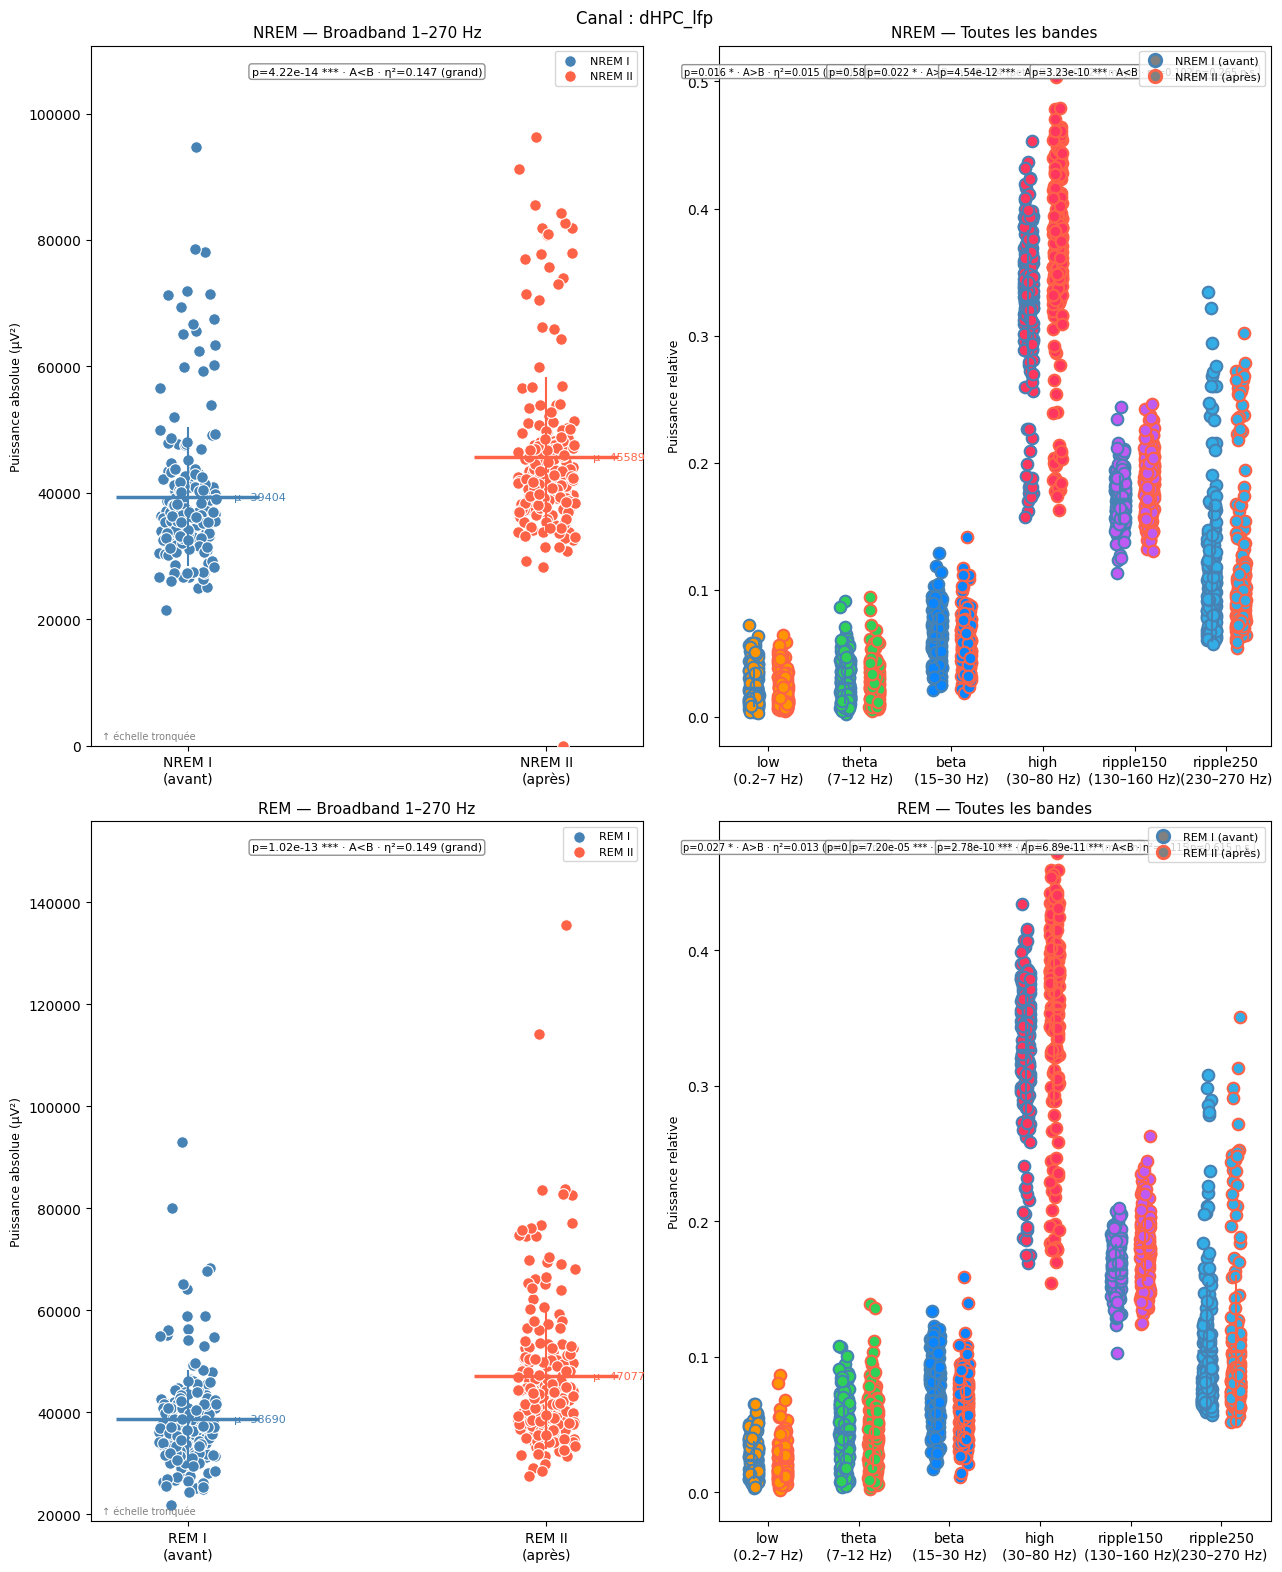

In [7]:
BROADBAND = (FMIN, FMAX)   # derived from FREQ_BANDS range

def all_band_powers(psds, freqs):
    broad_mask = (freqs >= BROADBAND[0]) & (freqs <= BROADBAND[1])
    total = psds[:, broad_mask].sum(axis=1)
    rel = {}
    for name, (lo, hi) in FREQ_BANDS.items():
        band_mask = (freqs >= lo) & (freqs <= hi)
        rel[name] = psds[:, band_mask].sum(axis=1) / total
    return rel, total


from matplotlib.lines import Line2D
from matplotlib.transforms import blended_transform_factory

band_names = list(FREQ_BANDS.keys())
n_bands    = len(band_names)

fig, axes = plt.subplots(2, 2, figsize=(13, 4 + 2 * n_bands))

for row, sleep_type in enumerate(["NREM", "REM"]):
    psd1 = psd_cache[(f"{sleep_type} I",  CHANNEL)]
    psd2 = psd_cache[(f"{sleep_type} II", CHANNEL)]
    rel1, broad1 = all_band_powers(psd1, freqs)
    rel2, broad2 = all_band_powers(psd2, freqs)

    # ── Left: broadband absolute ───────────────────────────────────────────
    ax = axes[row, 0]
    for x_pos, vals, color, cond in [
        (0, broad1, "steelblue", f"{sleep_type} I"),
        (1, broad2, "tomato",    f"{sleep_type} II"),
    ]:
        jitter = np.random.default_rng(1).uniform(-0.08, 0.08, size=len(vals))
        ax.scatter(x_pos + jitter, vals, color=color, s=70,
                   edgecolors="white", lw=0.8, zorder=3, label=cond)
        mean, std = vals.mean(), vals.std()
        ax.hlines(mean, x_pos - 0.2, x_pos + 0.2, colors=color, lw=2.5, zorder=4)
        ax.vlines(x_pos, mean - std,  mean + std,  colors=color, lw=1.5, zorder=4)
        ax.annotate(f"μ={mean:.0f}", xy=(x_pos + 0.13, mean),
                    fontsize=8, color=color, va="center")
    all_broad = np.concatenate([broad1, broad2])
    ax.set_ylim(all_broad.min() * 0.85, all_broad.max() * 1.15)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f"{sleep_type} I\n(avant)", f"{sleep_type} II\n(après)"], fontsize=10)
    ax.set_ylabel("Puissance absolue (µV²)", fontsize=9)
    ax.set_title(f"{sleep_type} — Broadband {BROADBAND[0]:.0f}–{BROADBAND[1]:.0f} Hz", fontsize=11)
    ax.annotate("↑ échelle tronquée", xy=(0.02, 0.01), xycoords="axes fraction",
                fontsize=7, color="grey")
    ax.text(0.5, 0.97, stat_label(broad1, broad2), transform=ax.transAxes,
            ha="center", va="top", fontsize=8,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.85, ec="grey"))
    ax.legend(fontsize=8)

    # ── Right: relative power all bands ───────────────────────────────────
    ax2 = axes[row, 1]
    group_gap, band_gap = 0.35, 1.1
    x_centers = np.arange(n_bands) * band_gap
    blended = blended_transform_factory(ax2.transData, ax2.transAxes)

    for i, name in enumerate(band_names):
        xc    = x_centers[i]
        color = BAND_COLORS_MAP[name]
        for x_g, vals, edge in [
            (xc - group_gap / 2, rel1[name], "steelblue"),
            (xc + group_gap / 2, rel2[name], "tomato"),
        ]:
            jitter = np.random.default_rng(2).uniform(-0.06, 0.06, size=len(vals))
            ax2.scatter(x_g + jitter, vals, color=color, edgecolors=edge,
                        linewidths=1.5, s=70, zorder=3)
            mean, std = vals.mean(), vals.std()
            ax2.hlines(mean, x_g - 0.12, x_g + 0.12, colors=edge, lw=2.5, zorder=4)
            ax2.vlines(x_g, mean - std,  mean + std,  colors=edge, lw=1.5, zorder=4)
        ax2.text(xc, 0.97, stat_label(rel1[name], rel2[name]),
                 transform=blended, ha="center", va="top", fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85, ec="grey"))

    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='grey',
               markeredgecolor='steelblue', markeredgewidth=2, markersize=9,
               label=f"{sleep_type} I (avant)"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='grey',
               markeredgecolor='tomato', markeredgewidth=2, markersize=9,
               label=f"{sleep_type} II (après)"),
    ]
    f_labels = [f"{n}\n({FREQ_BANDS[n][0]}–{FREQ_BANDS[n][1]} Hz)" for n in band_names]
    ax2.legend(handles=legend_handles, fontsize=8, loc="upper right")
    ax2.set_xticks(x_centers)
    ax2.set_xticklabels(f_labels, fontsize=10)
    ax2.set_ylabel("Puissance relative", fontsize=9)
    ax2.set_title(f"{sleep_type} — Toutes les bandes", fontsize=11)

plt.suptitle(f"Canal : {CHANNEL}", fontsize=12)
plt.tight_layout()
plt.show()

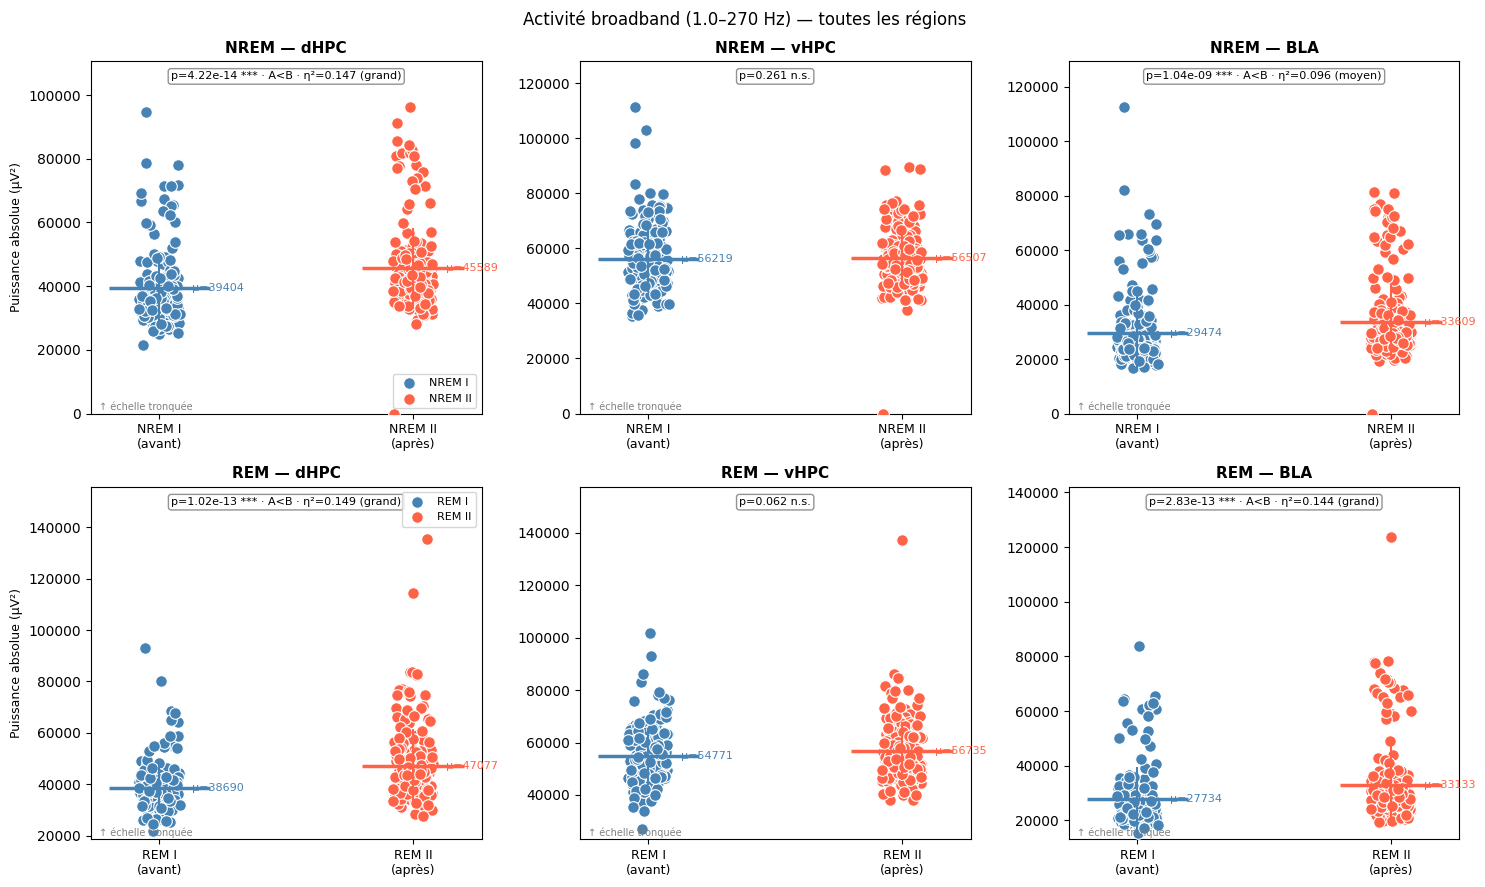

In [8]:
channels       = ["dHPC_lfp", "vHPC_lfp", "bla_lfp"]
channel_labels = ["dHPC",     "vHPC",     "BLA"]

fig, axes = plt.subplots(2, 3, figsize=(15, 9))

for row, sleep_type in enumerate(["NREM", "REM"]):
    for col, (ch, ch_label) in enumerate(zip(channels, channel_labels)):
        ax   = axes[row, col]
        pre  = psd_cache[(f"{sleep_type} I",  ch)]
        post = psd_cache[(f"{sleep_type} II", ch)]

        broad_mask = (freqs >= BROADBAND[0]) & (freqs <= BROADBAND[1])
        broad_pre  = pre[:,  broad_mask].sum(axis=1)
        broad_post = post[:, broad_mask].sum(axis=1)

        for x_pos, vals, color, cond in [
            (0, broad_pre,  "steelblue", f"{sleep_type} I"),
            (1, broad_post, "tomato",    f"{sleep_type} II"),
        ]:
            jitter = np.random.default_rng(3).uniform(-0.08, 0.08, size=len(vals))
            ax.scatter(x_pos + jitter, vals, color=color, s=70,
                       edgecolors="white", lw=0.8, zorder=3, label=cond)
            mean, std = vals.mean(), vals.std()
            ax.hlines(mean, x_pos - 0.2, x_pos + 0.2, colors=color, lw=2.5, zorder=4)
            ax.vlines(x_pos, mean - std,  mean + std,  colors=color, lw=1.5, zorder=4)
            ax.annotate(f"μ={mean:.0f}", xy=(x_pos + 0.13, mean),
                        fontsize=8, color=color, va="center")

        all_vals = np.concatenate([broad_pre, broad_post])
        ax.set_ylim(all_vals.min() * 0.85, all_vals.max() * 1.15)
        ax.set_xticks([0, 1])
        ax.set_xticklabels([f"{sleep_type} I\n(avant)", f"{sleep_type} II\n(après)"], fontsize=9)
        ax.set_title(f"{sleep_type} — {ch_label}", fontsize=11, fontweight="bold")
        ax.set_ylabel("Puissance absolue (µV²)" if col == 0 else "", fontsize=9)
        ax.annotate("↑ échelle tronquée", xy=(0.02, 0.01), xycoords="axes fraction",
                    fontsize=7, color="grey")
        ax.text(0.5, 0.97, stat_label(broad_pre, broad_post), transform=ax.transAxes,
                ha="center", va="top", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.85, ec="grey"))
        if col == 0:
            ax.legend(fontsize=8)

plt.suptitle(f"Activité broadband ({BROADBAND[0]}–{BROADBAND[1]} Hz) — toutes les régions",
             fontsize=12)
plt.tight_layout()
plt.show()

## 4. Comparaisons de bandes de fréquences — analyse statistique

Pour chaque paire de conditions on compare la **puissance relative** de chaque bande (theta, alpha, beta)
dans chacune des trois régions cérébrales.

**Test statistique** : Mann–Whitney U bilatéral (non-paramétrique, adapté à des échantillons potentiellement non-gaussiens).  
`***` p < 0.001 · `**` p < 0.01 · `*` p < 0.05 · `n.s.` non significatif

In [9]:
def comparison_plot(title, vals_a, vals_b, label_a, label_b):
    """
    n_bands × n_channels comparison grid with Mann-Whitney U annotation.
    Bands and colours are read from FREQ_BANDS / BAND_COLORS_MAP automatically.

    Parameters
    ----------
    title   : str — figure suptitle
    vals_a  : dict {ch: {band: np.ndarray}} — condition A
    vals_b  : dict {ch: {band: np.ndarray}} — condition B
    label_a : str — x-tick label for condition A
    label_b : str — x-tick label for condition B
    """
    bands    = list(FREQ_BANDS.keys())
    channels = CHANNELS_LIST
    n_bands, n_ch = len(bands), len(channels)

    fig, axes = plt.subplots(
        n_bands, n_ch,
        figsize=(5 * n_ch, 3.5 * n_bands),
        sharey="row", squeeze=False,
    )
    fig.suptitle(title, fontsize=13, fontweight="bold", y=1.01)

    rng = np.random.default_rng(42)

    for b_idx, band in enumerate(bands):
        color    = BAND_COLORS_MAP[band]
        lo, hi   = FREQ_BANDS[band]

        for c_idx, ch in enumerate(channels):
            ax     = axes[b_idx][c_idx]
            a_vals = vals_a[ch][band]
            b_vals = vals_b[ch][band]
            a_ok   = a_vals[np.isfinite(a_vals)]
            b_ok   = b_vals[np.isfinite(b_vals)]

            # ── Boxplot ────────────────────────────────────────────────
            bp = ax.boxplot(
                [a_ok, b_ok], positions=[0, 1], widths=0.45,
                patch_artist=True, showfliers=False,
                medianprops=dict(color="black", lw=2),
            )
            for patch, ec in zip(bp["boxes"], ["steelblue", "tomato"]):
                patch.set_facecolor(color)
                patch.set_edgecolor(ec)
                patch.set_alpha(0.55)
                patch.set_linewidth(2)

            # ── Strip plot ─────────────────────────────────────────────
            for x_pos, vals, ec in [(0, a_ok, "steelblue"), (1, b_ok, "tomato")]:
                jitter = rng.uniform(-0.06, 0.06, size=len(vals))
                ax.scatter(
                    x_pos + jitter, vals,
                    color=color, edgecolors=ec, linewidths=0.8,
                    s=20, alpha=0.6, zorder=3,
                )

            # ── Stat annotation ────────────────────────────────────────
            p_lbl = stat_label(a_vals, b_vals)
            ax.text(
                0.5, 0.97, p_lbl,
                transform=ax.transAxes,
                ha="center", va="top", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.85, ec="grey"),
            )

            # ── Labels ────────────────────────────────────────────────
            if b_idx == 0:
                ax.set_title(CHANNEL_LABELS[ch], fontsize=12, fontweight="bold")
            if c_idx == 0:
                ax.set_ylabel(f"{band}\n({lo}–{hi} Hz)\nRel. power", fontsize=8)
            ax.set_xticks([0, 1])
            ax.set_xticklabels([label_a, label_b], fontsize=9)

    plt.tight_layout()
    return fig

### 4a. NREM I vs NREM II

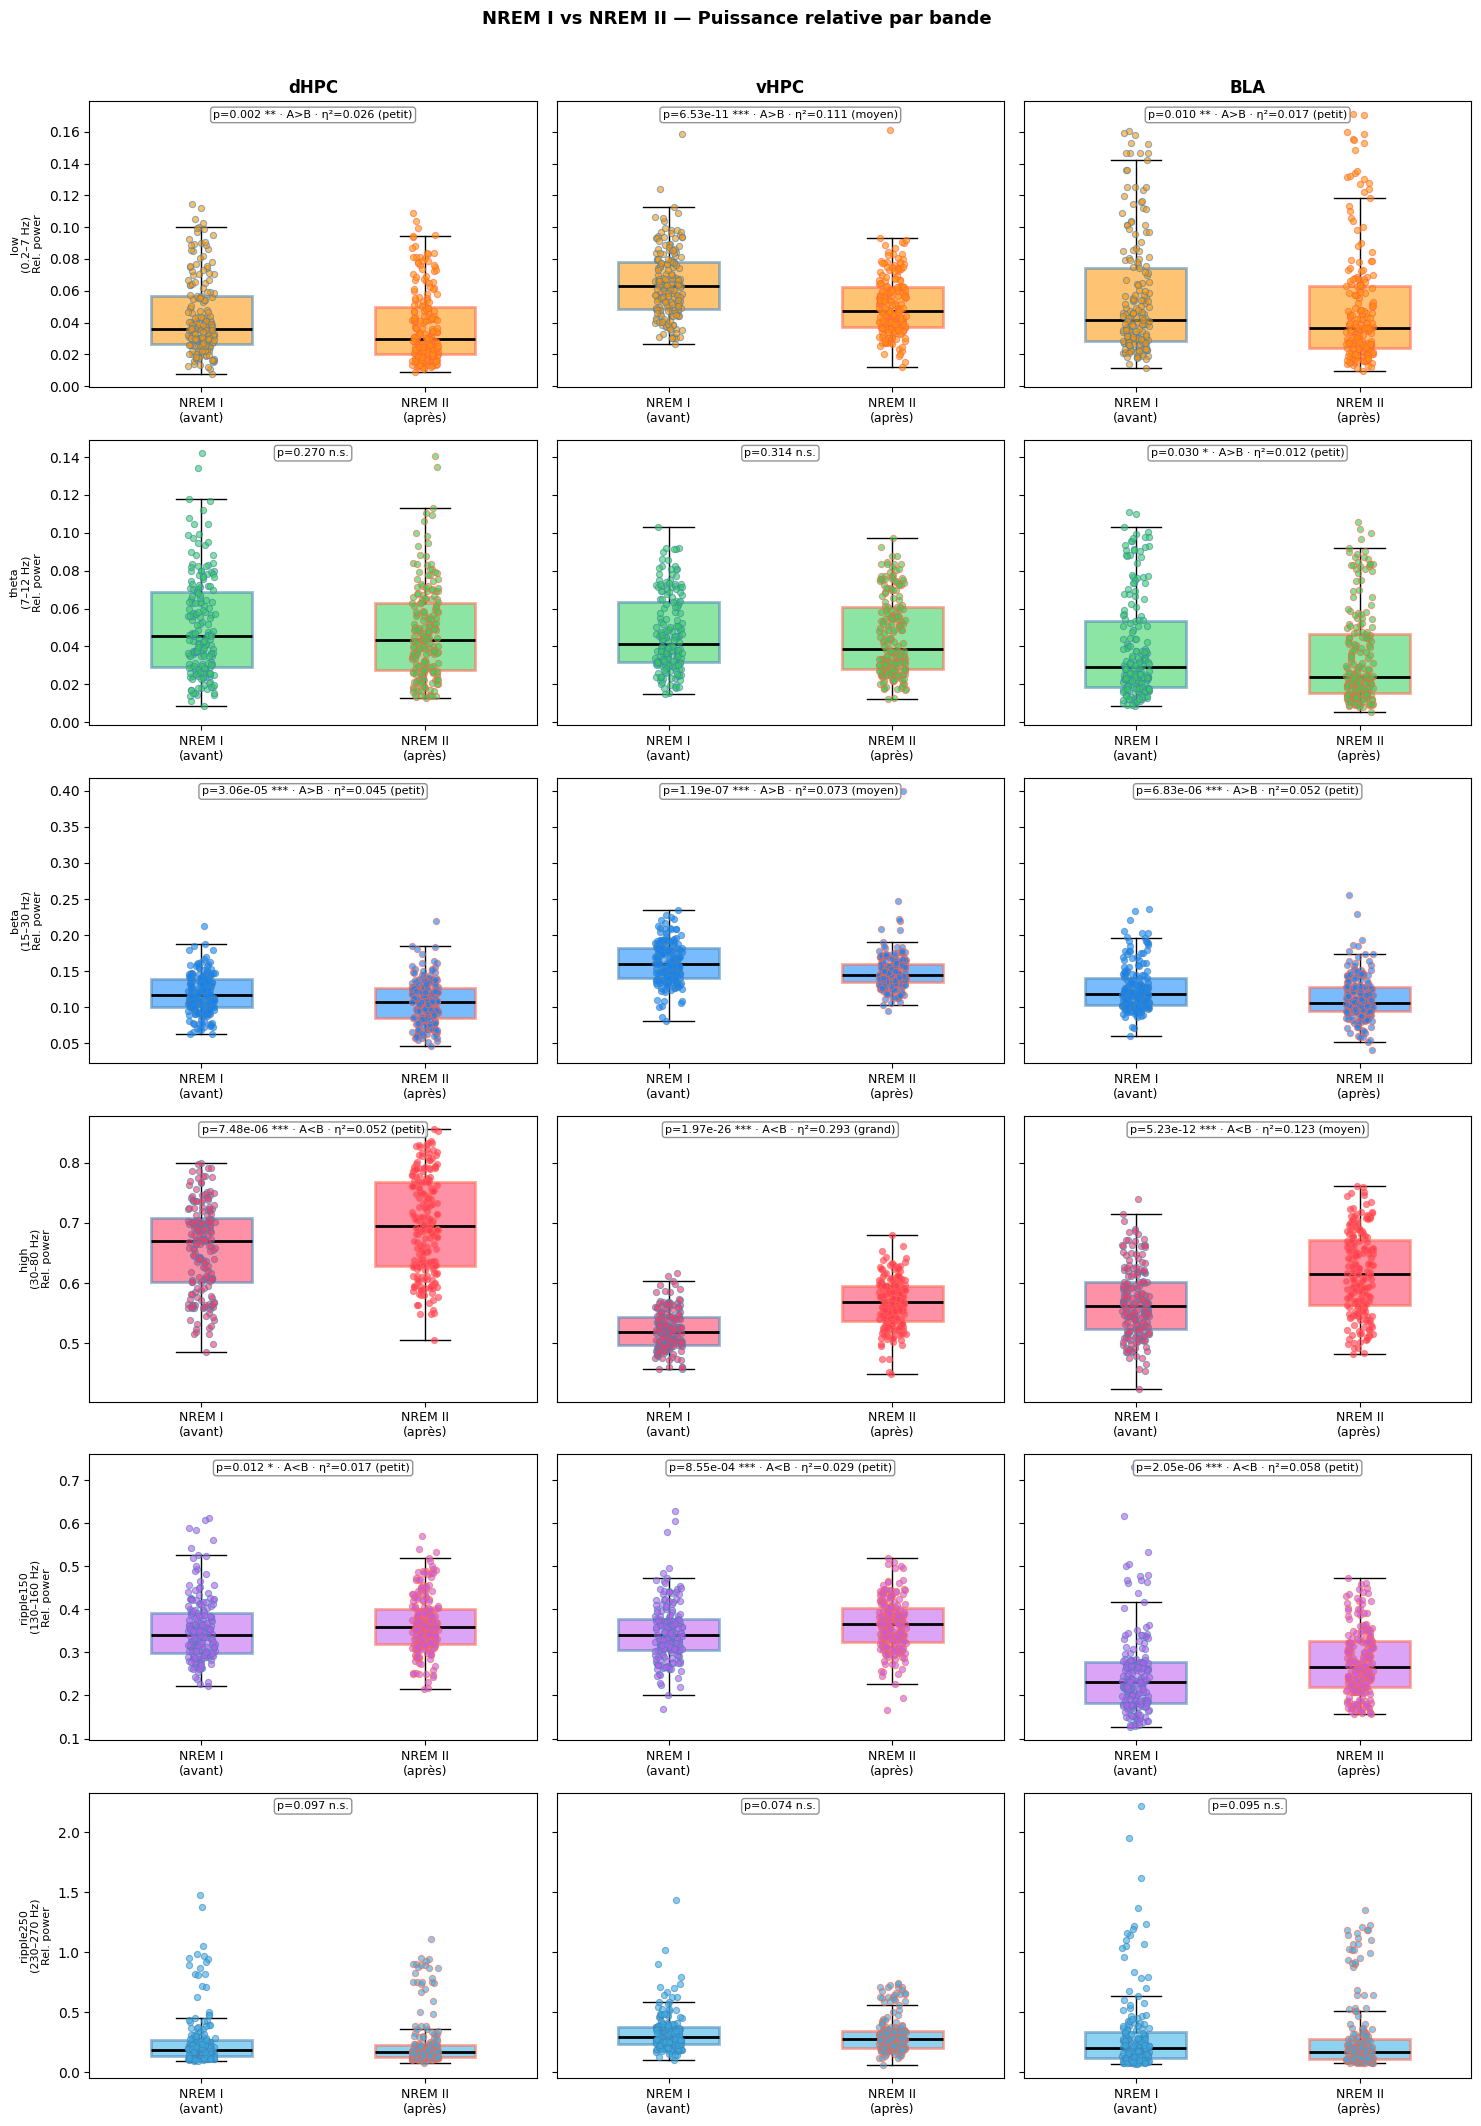

In [10]:
fig_nrem = comparison_plot(
    title="NREM I vs NREM II — Puissance relative par bande",
    vals_a={ch: band_powers[("NREM I",  ch)] for ch in CHANNELS_LIST},
    vals_b={ch: band_powers[("NREM II", ch)] for ch in CHANNELS_LIST},
    label_a="NREM I\n(avant)",
    label_b="NREM II\n(après)",
)
plt.show()

### 4b. REM I vs REM II

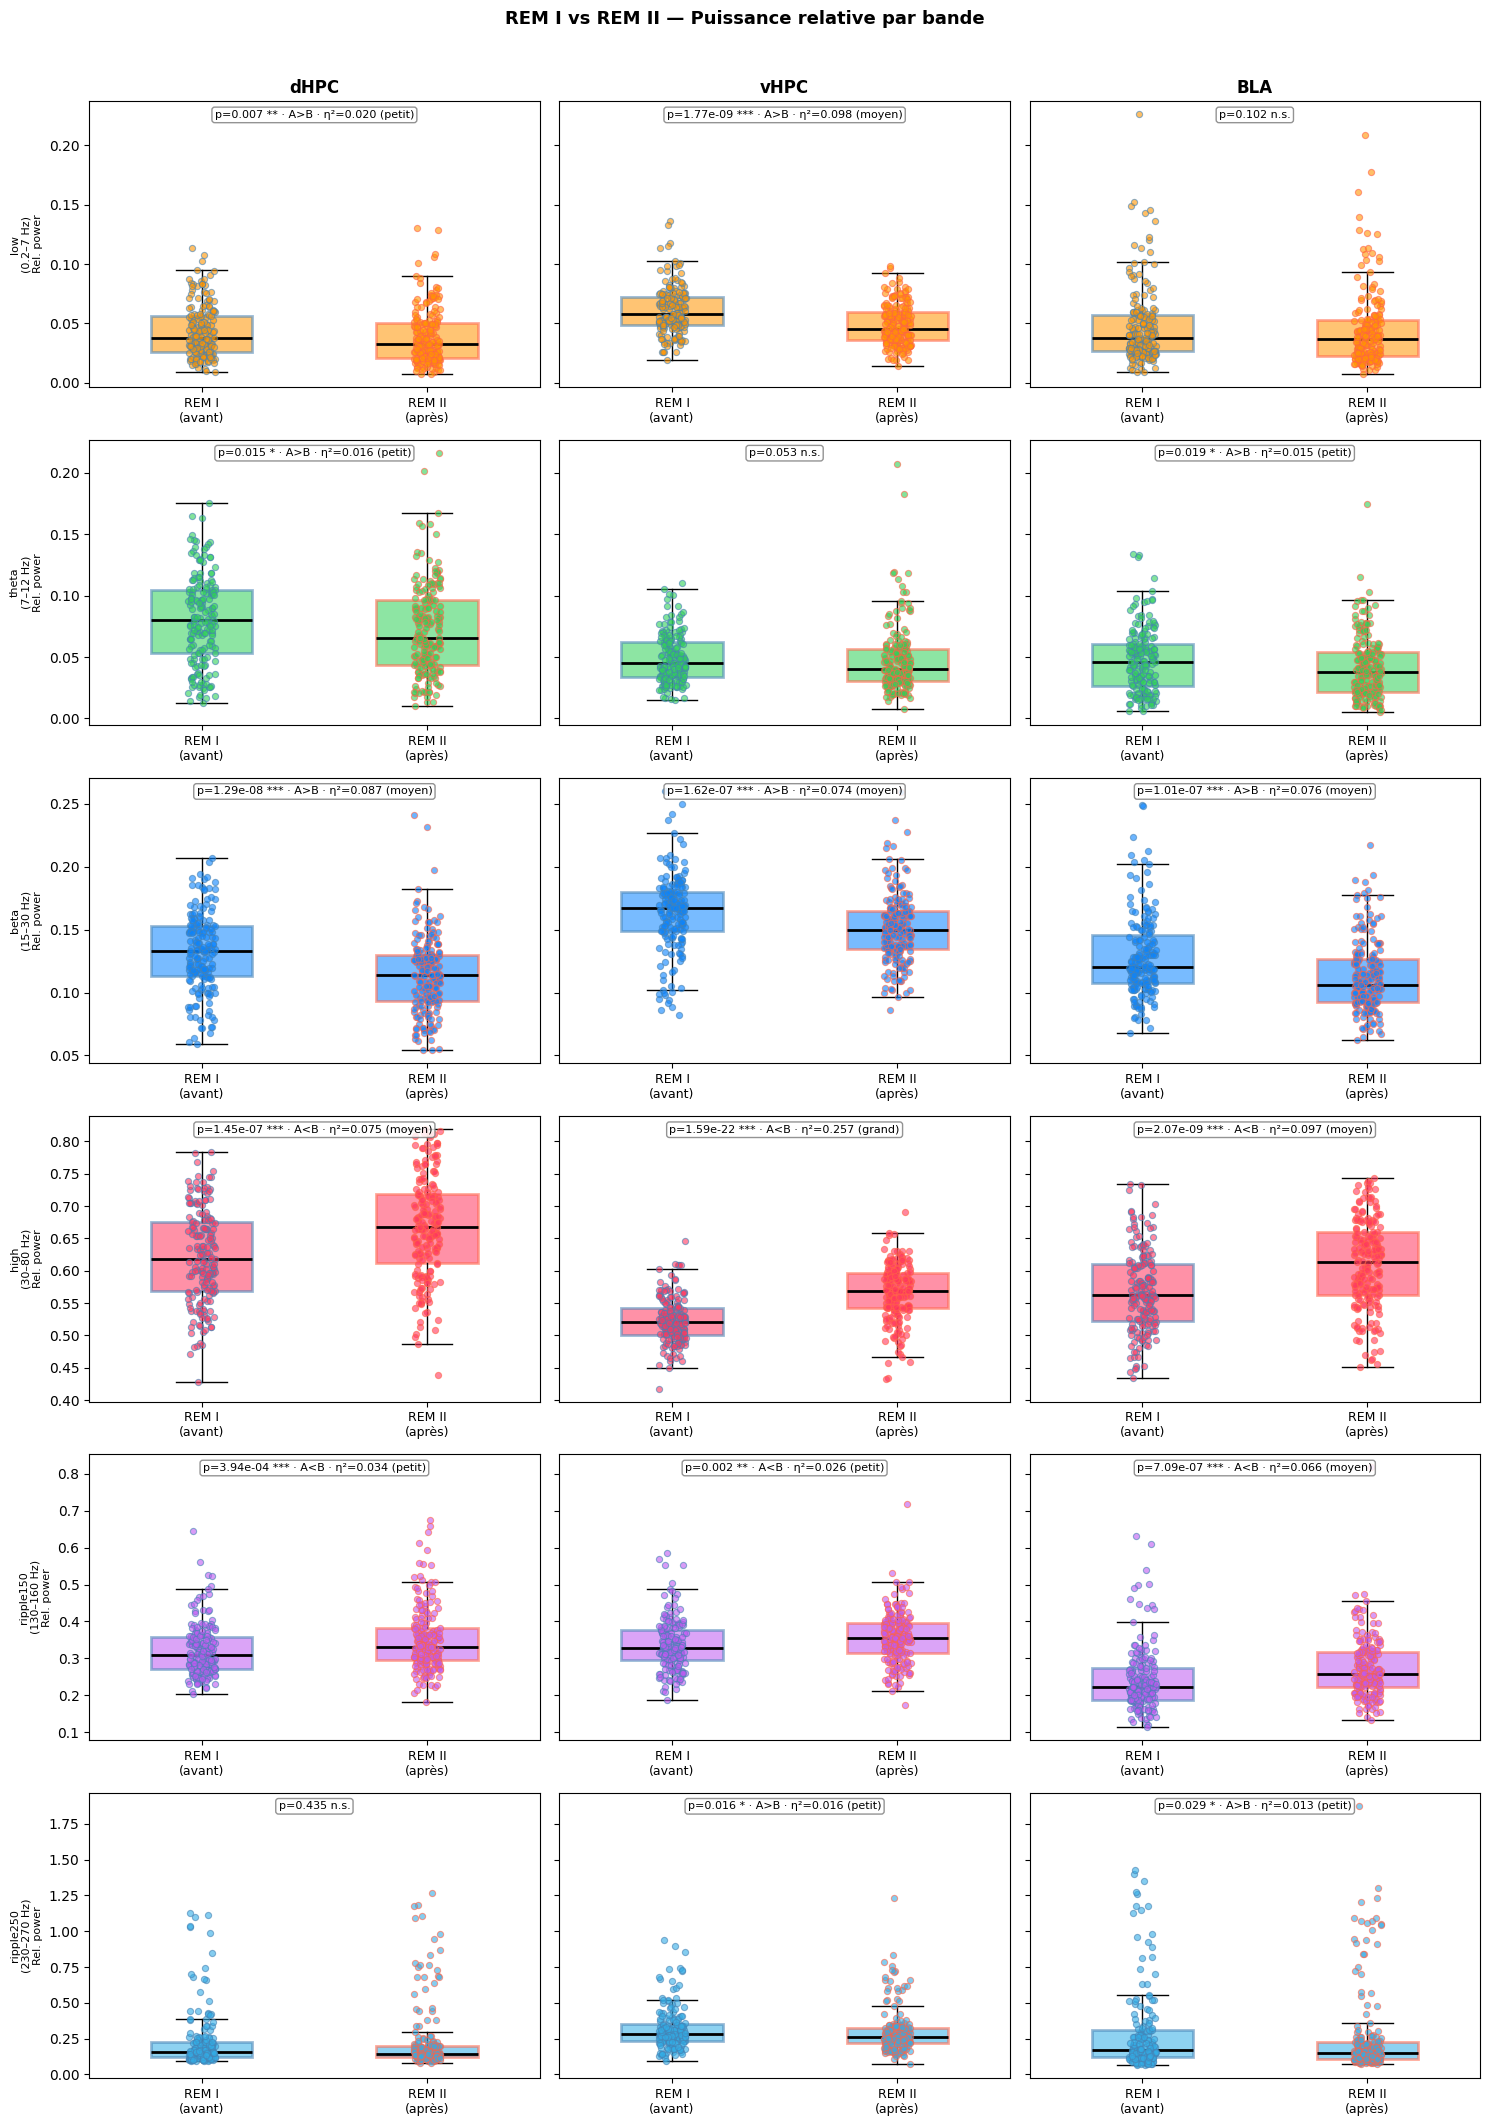

In [11]:
fig_rem = comparison_plot(
    title="REM I vs REM II — Puissance relative par bande",
    vals_a={ch: band_powers[("REM I",  ch)] for ch in CHANNELS_LIST},
    vals_b={ch: band_powers[("REM II", ch)] for ch in CHANNELS_LIST},
    label_a="REM I\n(avant)",
    label_b="REM II\n(après)",
)
plt.show()

### 4c. NREM global vs REM global (toutes epochs poolées)

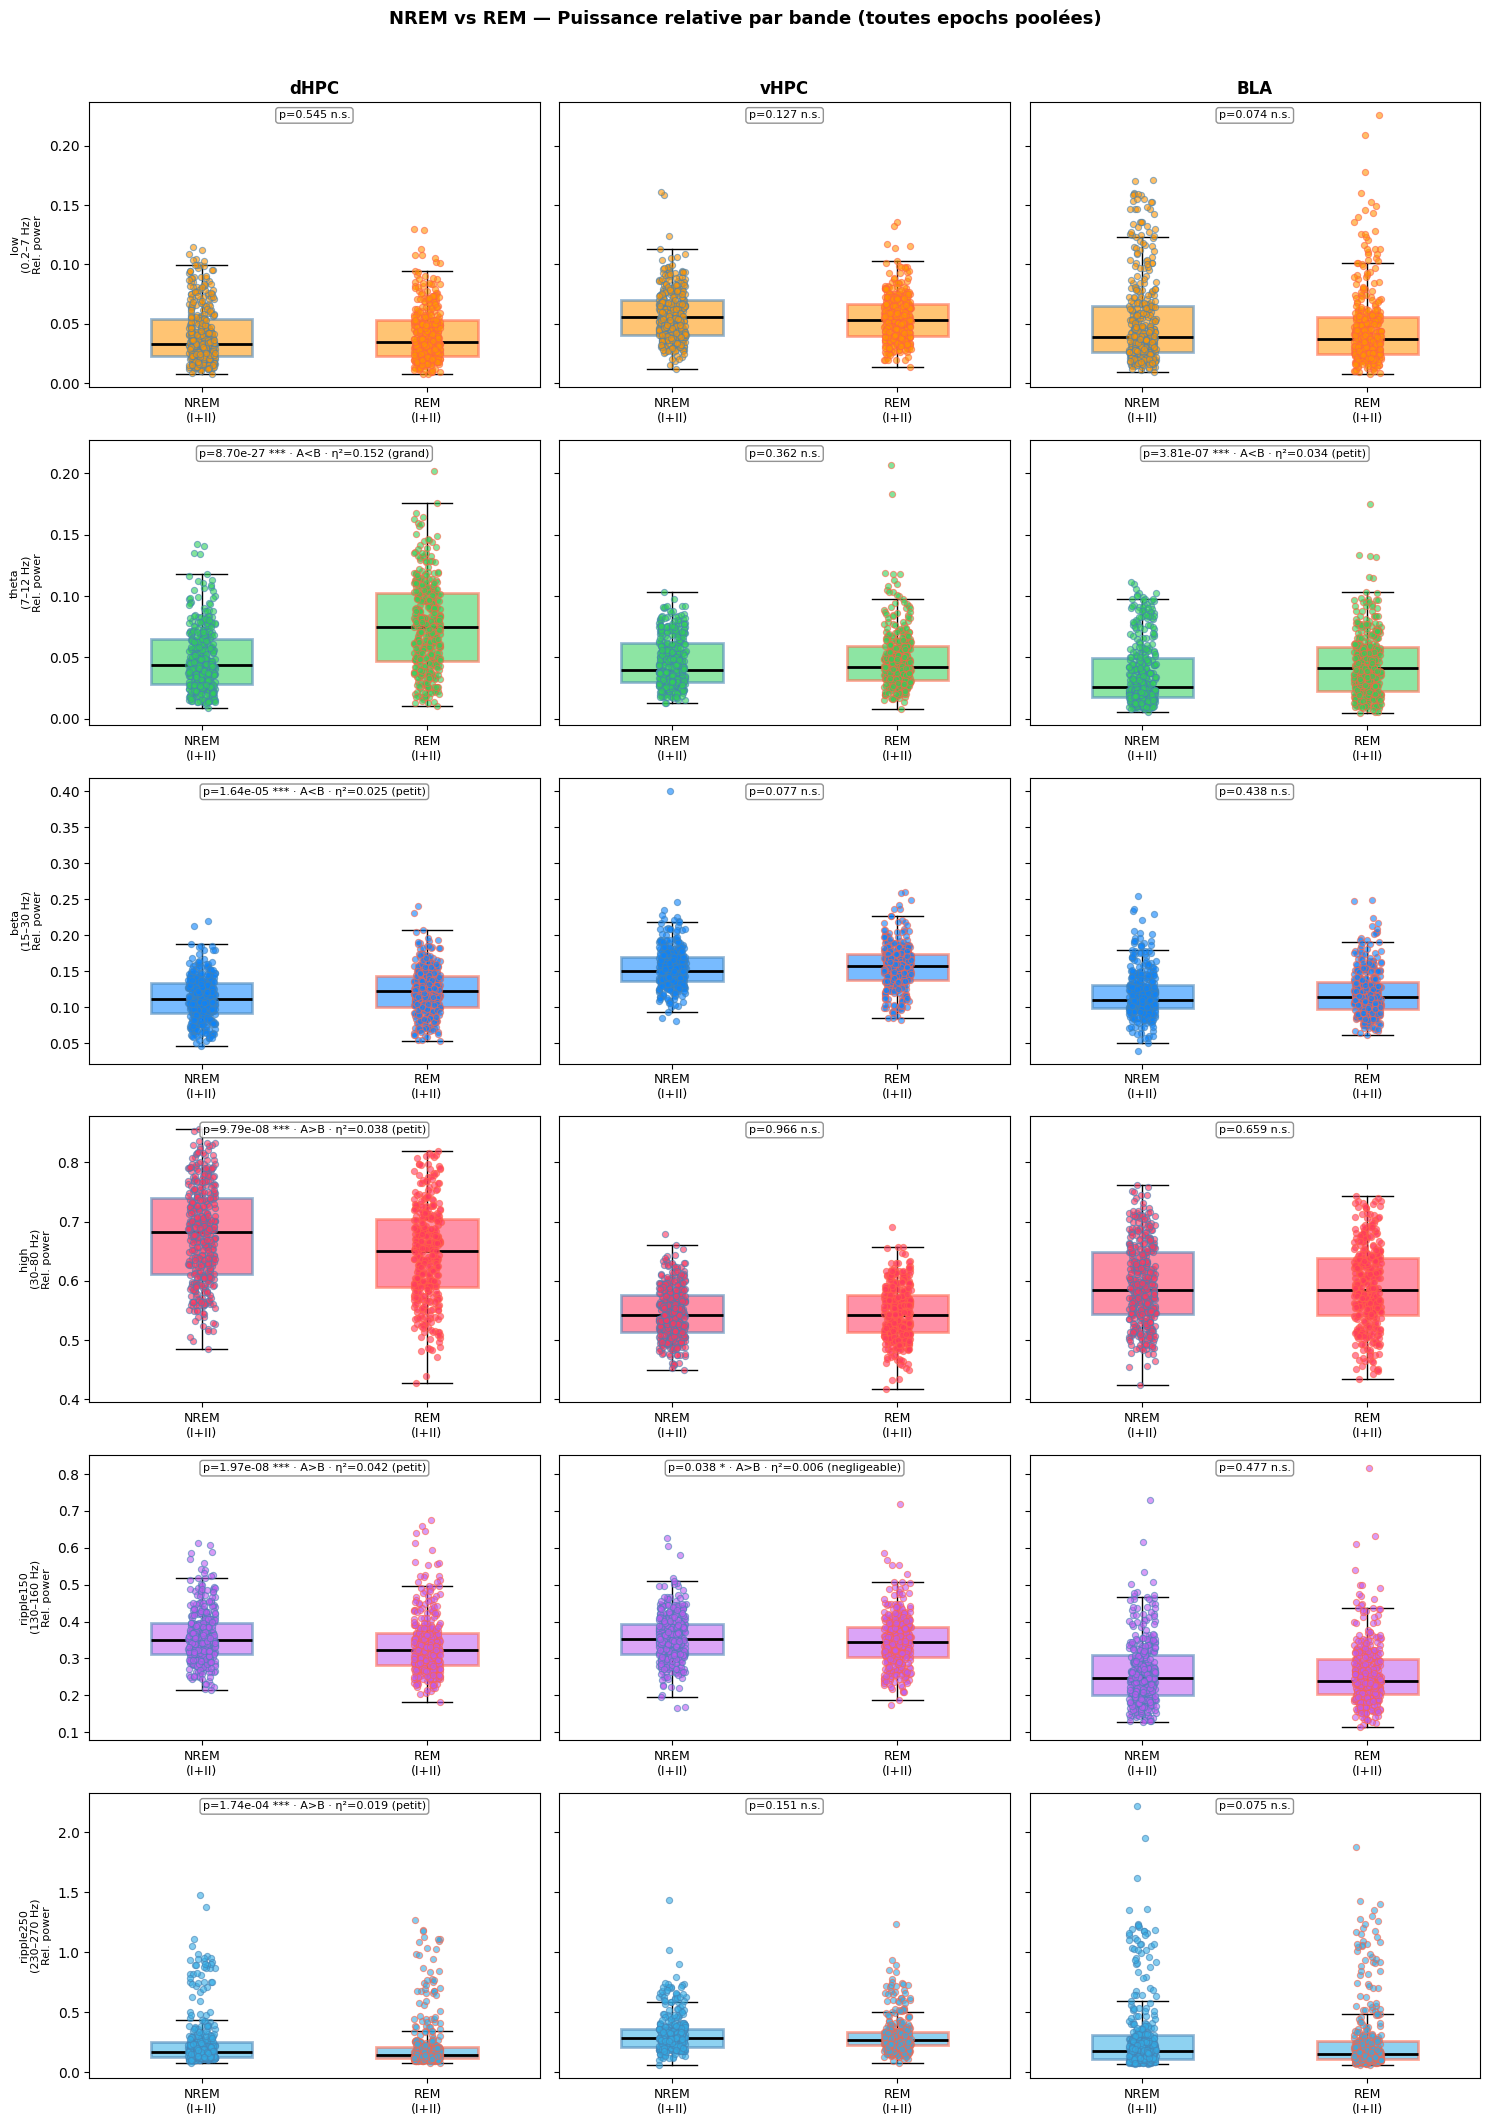

In [12]:
# Pool NREM I + II and REM I + II for each channel and band
nrem_pooled = {
    ch: {
        band: np.concatenate([
            band_powers[("NREM I",  ch)][band],
            band_powers[("NREM II", ch)][band],
        ])
        for band in FREQ_BANDS
    }
    for ch in CHANNELS_LIST
}
rem_pooled = {
    ch: {
        band: np.concatenate([
            band_powers[("REM I",  ch)][band],
            band_powers[("REM II", ch)][band],
        ])
        for band in FREQ_BANDS
    }
    for ch in CHANNELS_LIST
}

fig_nrem_vs_rem = comparison_plot(
    title="NREM vs REM — Puissance relative par bande (toutes epochs poolées)",
    vals_a=nrem_pooled,
    vals_b=rem_pooled,
    label_a="NREM\n(I+II)",
    label_b="REM\n(I+II)",
)
plt.show()

## 5. Résumé statistique complet

In [13]:
from scipy.stats import mannwhitneyu as _mwu

def full_stat(a, b):
    """Mann-Whitney U with rank-biserial r, η² and direction."""
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if len(a) < 2 or len(b) < 2:
        return None
    U, p = _mwu(a, b, alternative="two-sided")
    n_a, n_b = len(a), len(b)
    r       = 2 * U / (n_a * n_b) - 1
    mu_U    = n_a * n_b / 2
    sigma_U = np.sqrt(n_a * n_b * (n_a + n_b + 1) / 12)
    Z       = (U - mu_U) / sigma_U
    eta2    = Z**2 / (n_a + n_b)
    eta_lbl = ("negligeable" if eta2 < 0.01 else "petit" if eta2 < 0.06
               else "moyen" if eta2 < 0.14 else "grand")
    return dict(U=U, p=p, n_a=n_a, n_b=n_b,
                med_a=np.median(a), med_b=np.median(b),
                r=r, eta2=eta2, eta_lbl=eta_lbl)

def stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "n.s."

def print_stat(label_a, label_b, name, s):
    if s is None:
        print(f"    {name:<10s}  n.a.")
        return
    sig       = stars(s["p"])
    direction = f"{label_a} > {label_b}" if s["r"] > 0 else f"{label_a} < {label_b}"
    print(
        f"    {name:<10s}  "
        f"median {s['med_a']:.4f} vs {s['med_b']:.4f}  |  "
        f"U={s['U']:.0f}  p={s['p']:.4f}  {sig:<5s}  "
        f"η²={s['eta2']:.4f} ({s['eta_lbl']:<11s})  "
        f"{direction}  (n={s['n_a']} vs {s['n_b']})"
    )

SEP  = "─" * 115
SEP2 = "═" * 115

# ══════════════════════════════════════════════════════════════════════════
print(SEP2)
print("  STATISTIQUES — Mann-Whitney U bilatéral  |  Puissance relative par bande")
print("  η² = Z²/N  |  η²<0.01 négligeable · <0.06 petit · <0.14 moyen · ≥0.14 grand")
print(SEP2)

# ── 1. NREM I vs NREM II ──────────────────────────────────────────────────
print("\n▌ NREM I vs NREM II")
for ch in CHANNELS_LIST:
    print(f"\n  {CHANNEL_LABELS[ch]}")
    print(f"  {SEP[:85]}")
    for band in FREQ_BANDS:
        print_stat("NREM I", "NREM II", band,
                   full_stat(band_powers[("NREM I",  ch)][band],
                             band_powers[("NREM II", ch)][band]))

# ── 2. REM I vs REM II ────────────────────────────────────────────────────
print(f"\n{SEP}")
print("\n▌ REM I vs REM II")
for ch in CHANNELS_LIST:
    print(f"\n  {CHANNEL_LABELS[ch]}")
    print(f"  {SEP[:85]}")
    for band in FREQ_BANDS:
        print_stat("REM I", "REM II", band,
                   full_stat(band_powers[("REM I",  ch)][band],
                             band_powers[("REM II", ch)][band]))

# ── 3. NREM vs REM (pooled) ───────────────────────────────────────────────
print(f"\n{SEP}")
print("\n▌ NREM global vs REM global (poolé)")
for ch in CHANNELS_LIST:
    print(f"\n  {CHANNEL_LABELS[ch]}")
    print(f"  {SEP[:85]}")
    for band in FREQ_BANDS:
        a = np.concatenate([band_powers[("NREM I",  ch)][band],
                            band_powers[("NREM II", ch)][band]])
        b = np.concatenate([band_powers[("REM I",   ch)][band],
                            band_powers[("REM II",  ch)][band]])
        print_stat("NREM", "REM", band, full_stat(a, b))

print(f"\n{SEP2}\n")

═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════
  STATISTIQUES — Mann-Whitney U bilatéral  |  Puissance relative par bande
  η² = Z²/N  |  η²<0.01 négligeable · <0.06 petit · <0.14 moyen · ≥0.14 grand
═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════

▌ NREM I vs NREM II

  dHPC
  ─────────────────────────────────────────────────────────────────────────────────────
    low         median 0.0362 vs 0.0295  |  U=22054  p=0.0015  **     η²=0.0260 (petit      )  NREM I > NREM II  (n=184 vs 202)
    theta       median 0.0455 vs 0.0434  |  U=19793  p=0.2697  n.s.   η²=0.0032 (negligeable)  NREM I > NREM II  (n=184 vs 202)
    beta        median 0.1167 vs 0.1073  |  U=23149  p=0.0000  ***    η²=0.0450 (petit      )  NREM I > NREM II  (n=184 vs 202)
    high        median 0.6701 vs 0.6946  |  U=13679  p=0.0000  ***    η²=0.0520 (petit      )  NREM I < NREM II  (